#### Using WIN M1 Metatrader 5 data

Implementing Saulo's arbitrage algo

The idea is to train a guided system that learns and ajusts itself with its owns errors.  
That's the idea of a kalman's filter.   
The base for the first decision is the Bollinger Bands Algo.  
That's the most powerfull algo, based on the regression toward the mean law!

In [1]:
%matplotlib inline 

In [2]:
pwd

'/home/andre/Projects/stocks/prototypes'

In [3]:
cd ..

/home/andre/Projects/stocks


In [4]:
from matplotlib import pyplot as plt
import os
import sys
import pandas as pd
import numpy as np
import struct
import datetime
import calendar
import time
import argparse
import seaborn as sns
from algos import meta5Ibov
from algos.util import progressbar
from algos import bbands
from algos import meta5Ibov

import torch as th
import scipy
import talib as ta
from numba import jit

In [5]:
cd data

/home/andre/Projects/stocks/data


In [6]:
pwd

'/home/andre/Projects/stocks/data'

In [7]:
# meta5Ibov.setDataPath(r'C:\\Users\\alferreira\\Documents\\stocks\\data', 
#                      r'C:\\Users\\alferreira\\Documents\\stocks\\data')
meta5Ibov.setDataPath(r'/home/andre/Projects/stocks/data', 
                        r'/home/andre/Projects/stocks/data')


Master data loaded size (minutes):  509471
symbols loaded:
['BBAS3' 'DOL$' 'VALE3' 'ABEV3' 'ITUB4' 'B3SA3' 'BBDC4' 'PETR4' 'WIN@']


#### Using M1 Data but could be M15 data etc.

Saulo used 10 seconds interval

In [8]:
#meta5Ibov.loadMeta5Data(preload=False);
meta5Ibov.loadMeta5Data();

Master data loaded size (minutes):  509471
symbols loaded:
['BBAS3' 'DOL$' 'VALE3' 'ABEV3' 'ITUB4' 'B3SA3' 'BBDC4' 'PETR4' 'WIN@']
Using previous loaded data!


In [9]:
bars = meta5Ibov.getSymbol('WIN@')

### Must be done otherwise will have 8 columns of data prior creating signal features

In [10]:
del bars['S'] 

In [14]:
datetimes = bars.index

In [22]:
datetimes.

<bound method Index.get_values of DatetimeIndex(['2014-01-02 10:06:00', '2014-01-02 10:07:00',
               '2014-01-02 10:08:00', '2014-01-02 10:09:00',
               '2014-01-02 10:10:00', '2014-01-02 10:11:00',
               '2014-01-02 10:12:00', '2014-01-02 10:13:00',
               '2014-01-02 10:14:00', '2014-01-02 10:15:00',
               ...
               '2019-01-17 17:45:00', '2019-01-17 17:46:00',
               '2019-01-17 17:47:00', '2019-01-17 17:48:00',
               '2019-01-17 17:49:00', '2019-01-17 17:50:00',
               '2019-01-17 17:51:00', '2019-01-17 17:52:00',
               '2019-01-17 17:53:00', '2019-01-17 17:54:00'],
              dtype='datetime64[ns]', name='time', length=509471, freq=None)>

In [50]:
%%time
days = datetimes.to_period('D')
dayint = days.asi8

CPU times: user 32.9 ms, sys: 44 µs, total: 33 ms
Wall time: 32.3 ms


In [52]:
len(dayint), len(datetimes)

(509471, 509471)

Not enough memory on local machine

In [12]:
bars = bars[-5000:]

In [13]:
# Indicadores
# Bollinger, MACD, SMA, EMA

In [14]:
#dow['OHLC'] = dow.apply(lambda row: np.mean([row['O'], row['H'], row['L'], row['C']]), axis=1) 
bars['OHLC'] = np.nan # typical price
bars.OHLC.values[:] = np.mean(bars.values[:,0:4], axis=1) # 1000x faster

In [15]:
# needed to reset orders by day, day id
bars['date'] = bars.index.date
bars.date = bars.apply(lambda x: x.date.toordinal(), axis=1) # integer day from year 1 day 1 gregorian day

In [16]:
# # (to unix timestamp) from nano seconds 10*9 to seconds //60 to minutes
# dow.index.astype(np.int64)//10**9

In [17]:
bars.head(1)

,O,H,L,C,TV,RV,OHLC,date
time,,,,,,,,
2018-11-27 11:25:00,86190.0,86195.0,86135.0,86160.0,1544,4907,86170.0,737025


In [18]:
bars.shape

(5000, 8)

In [19]:
window=21; nbands=3 # number of bbands

#### Calculate 6 bollinger bands

starting with 0.5xjanela= 0.5x360=180  
increasing so the 6 bollinger bands have lengths  
180, 360, 540, 720, 1080  
#### For each band get signals of buy/sell or hold  

#### Calculate bands first and drop nan's at the beginning

nan's due the EMA's using previous values

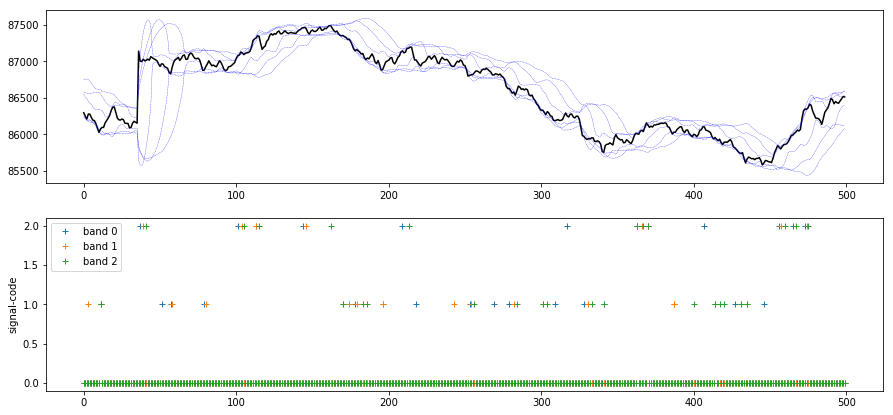

In [20]:
lastn=-500
verbose=True
price = bars.OHLC.values
inc=0.5
for i in range(nbands):
    upband, sma, lwband =  ta.BBANDS(price, window*inc)
    bars['bandlw'+str(i)] = lwband
    bars['bandup'+str(i)] = upband
    bars['bandsg'+str(i)] = 0 # signal for this band
    signals = bbands.bollingerSignal(price[1:], price[:-1],
                              upband[1:], upband[:-1], lwband[1:], lwband[:-1])
    bars.loc[1:, 'bandsg'+str(i)] = signals.astype(int) # signal for this band
    inc += 0.5
bars.dropna(inplace=True)

# if verbose plotting
lastn=-500
if verbose:
    plt.figure(figsize=(15,7))
    plt.subplot(2, 1, 1)
    plt.plot(price[lastn:], 'k-')
    for i in range(nbands):
        # plot bands
        plt.plot(bars['bandup'+str(i)].values[lastn:], 'b--', lw=0.3)
        plt.plot(bars['bandlw'+str(i)].values[lastn:], 'b--', lw=0.3)
    plt.subplot(2, 1, 2)
    for i in range(nbands):
        plt.plot(bars['bandsg'+str(i)].values[lastn:], '+', label='band '+str(i))
        plt.ylabel('signal-code')
    plt.legend()
#     plt.savefig('bbands.png')
#     plt.close()

In [21]:
bars.dropna(inplace=True)

In [22]:
len(bars)

4970

#### batch signal vector is N dimensional composed of signals for each band + thousand indicators

batch.append([sigb0, sigb1, ..., sigb5, askv, bidv])

may/should increase this here with other indicators

#### Need to traverse every band calculating 

- profit
- real Y class (buy, hold, sell)

In [23]:
for j in range(nbands): # for each band traverse it
    bars['y'+str(j)] = np.nan
    ibandsg = bars.columns.get_loc('bandsg'+str(j))
    iyband = bars.columns.get_loc('y'+str(j))    
    # being pessimistic ... is this right?
    # should i buy at what price? I dont know maybe the typical one is more realistic.
    # but setting the worst case garantees profit in the worst scenario!!
    # better.
    # So i Buy at the highest price and sell at the lowest one.
    yband = bbands.traverseBand(bars.iloc[:, ibandsg].values.astype(int),
                                    bars.iloc[:, iyband].values,
                                    bars.H.values, bars.L.values, bars.date.values)
    bars.iloc[:, iyband] = yband

In [24]:
bars.memory_usage(index=True).sum()//(1024*1024) # MBytes

0

### Taking a look on the target class for each band

In [25]:
#tmp = dow.dropna()
columns = ['y'+str(j) for j in range(nbands)]
tmp = bars[columns]
ys = tmp.dropna(how='all')

In [26]:
ys.head()

,y0,y1,y2
time,,,
2018-11-27 11:57:00,0.0,NaN,NaN
2018-11-27 12:16:00,1.0,NaN,NaN
2018-11-27 12:18:00,NaN,1.0,NaN
2018-11-27 12:19:00,NaN,NaN,1.0
2018-11-27 12:37:00,2.0,NaN,NaN


### In average how long it takes to close a position

** reseted by day**

In [27]:
@jit
def close_time(yserie):
    buy = False
    times = []
    buytime = None
    for i in range(yserie.size):
        if yserie[i] == 1:
            buy = True
            buytime = yserie.index[i]
        elif yserie[i] == 2 and buy == True: #selling that
            selltime = yserie.index[i]
            #print('diff ', selltime-buytime)
            times.append(selltime-buytime)
            buy = False
    return np.array(times)

In [28]:
times = np.array([])
for i in range(nbands):
    times = np.append(times, close_time(ys['y'+str(i)]))

In [29]:
times = np.array(list(map(lambda x: x.total_seconds()/60, times)))

In [30]:
print('p0: {:.1f} p1: {:.1f} p10: {:.1f} p50: {:.1f} p90: {:.1f}'.format(*np.percentile(times, [0, 1, 10, 50, 90])))

p0: 6.0 p1: 7.0 p10: 10.0 p50: 21.5 p90: 38.2


In [31]:
np.max(times)

89.0

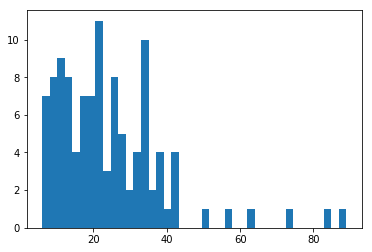

In [32]:
plt.hist(times, bins=40);

In [33]:
from scipy.stats import percentileofscore

In [34]:
percentileofscore(times, 46)

94.54545454545455

In [35]:
ys[ ys == 2] = -1
ys = ys[ ys != 0 ]
ys.dropna(how='all', inplace=True) # due getting only !=0 

/home/andre/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._where(-key, value, inplace=True)


In [36]:
ys.head(10)

,y0,y1,y2
time,,,
2018-11-27 12:16:00,1.0,NaN,NaN
2018-11-27 12:18:00,NaN,1.0,NaN
2018-11-27 12:19:00,NaN,NaN,1.0
2018-11-27 12:37:00,-1.0,NaN,NaN
2018-11-27 12:39:00,1.0,NaN,NaN
2018-11-27 12:56:00,-1.0,NaN,NaN
2018-11-27 13:01:00,NaN,-1.0,NaN
2018-11-27 13:02:00,NaN,NaN,-1.0
2018-11-27 14:38:00,1.0,NaN,NaN


### Getting only entry points for each band

In [37]:
hys = ys[ys > 0].count(axis=0)

Text(0.5, 0, 'band number')

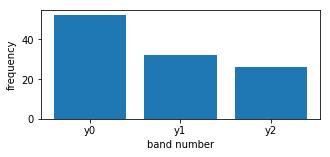

In [38]:
plt.figure(figsize=(5,2))
plt.bar(hys.index, hys.values)
plt.ylabel('frequency')
plt.xlabel('band number')

### - If it's going up it's going up. 
### - If it's time to close the position it's to close. 

### - There is no crossed signals between bands.

So we can allways sum them up to see average results. 

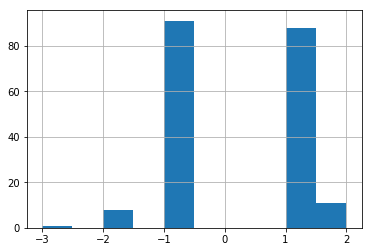

In [39]:
ys.sum(axis=1).hist()

### Since a buy signal in any of the bands is an entry point 

Calculate percentage %  of entries 

In [40]:
entries = ys[ys > 0]

In [41]:
entries.dropna(how='all', inplace=True)

In [42]:
percentries = len(entries)/(len(bars)) 

In [43]:
print("percent entries {:.2f} %".format(percentries*100))

percent entries 1.99 %


### average per day deals

In [44]:
print("percent entries per day {:.1f}".format(percentries*60*7))

percent entries per day 8.4


### Now assembly X and Y vectors

EACH training vector is a pair:

- `X` (of a band-signal + signal features) 
- `y` (result for this signal 0/1/2) 

So for example if a signal is for 3 different bands we will have 3 training pairs.  

**window*nsignal features X second dimension**

### Signal Features for X first

altough S is nothing let it be there

In [45]:
bars.columns

Index(['O', 'H', 'L', 'C', 'TV', 'RV', 'OHLC', 'date', 'bandlw0', 'bandup0',
       'bandsg0', 'bandlw1', 'bandup1', 'bandsg1', 'bandlw2', 'bandup2',
       'bandsg2', 'y0', 'y1', 'y2'],
      dtype='object')

In [46]:
# ## Signal Features
bars.RV = np.log(bars.RV+5)
bars.TV = np.log(bars.TV+5) # to avoid division by zero/inf etc
# tecnical indicators features
inc = 0.5
for column in bars.columns[:7]: # ignore date/dated
    for i in range(nbands):      # 1e-8 to avoid creating nans
        ema =  ta.EMA(bars[column].values.astype(np.float64), window*inc)
        sfx = str(column)+str(i)  # name suffix
        # remove nbands emas
        bars['dema'+sfx] = bars[column] - ema
        bars.loc[:, 'demav'+sfx] = np.nan
        # return of the differences to the ema (know to have good response for prediction)
        bars.loc[1:, 'demav'+sfx] = bars['dema'+sfx].values[:-1]/(1e-8+bars['dema'+sfx].values[1:])
        macd, sg, ht = ta.MACD(bars[column].values.astype(np.float64),
                               int(window*inc*0.5), int(window*0.75*inc), int(0.25*inc*window))
        #dow.loc[:, 'macd'+sfx] = macd
        bars.loc[:, 'dmacdv'+sfx] = np.nan
        bars.loc[1:, 'dmacdv'+sfx] = macd[:-1]/(1e-8+macd[1:])
        inc += 0.5
# day information signal [0, 1]
bars['dated'] = 0
for i, vars in enumerate(bars.groupby(bars.date)):
    day, group = vars
    bars.loc[group.index, 'dated'] = 1 if i%2==0 else 0 # odd or even day change

In [47]:
bars.columns

Index(['O', 'H', 'L', 'C', 'TV', 'RV', 'OHLC', 'date', 'bandlw0', 'bandup0',
       'bandsg0', 'bandlw1', 'bandup1', 'bandsg1', 'bandlw2', 'bandup2',
       'bandsg2', 'y0', 'y1', 'y2', 'demaO0', 'demavO0', 'dmacdvO0', 'demaO1',
       'demavO1', 'dmacdvO1', 'demaO2', 'demavO2', 'dmacdvO2', 'demaH0',
       'demavH0', 'dmacdvH0', 'demaH1', 'demavH1', 'dmacdvH1', 'demaH2',
       'demavH2', 'dmacdvH2', 'demaL0', 'demavL0', 'dmacdvL0', 'demaL1',
       'demavL1', 'dmacdvL1', 'demaL2', 'demavL2', 'dmacdvL2', 'demaC0',
       'demavC0', 'dmacdvC0', 'demaC1', 'demavC1', 'dmacdvC1', 'demaC2',
       'demavC2', 'dmacdvC2', 'demaTV0', 'demavTV0', 'dmacdvTV0', 'demaTV1',
       'demavTV1', 'dmacdvTV1', 'demaTV2', 'demavTV2', 'dmacdvTV2', 'demaRV0',
       'demavRV0', 'dmacdvRV0', 'demaRV1', 'demavRV1', 'dmacdvRV1', 'demaRV2',
       'demavRV2', 'dmacdvRV2', 'demaOHLC0', 'demavOHLC0', 'dmacdvOHLC0',
       'demaOHLC1', 'demavOHLC1', 'dmacdvOHLC1', 'demaOHLC2', 'demavOHLC2',
       'dmacdvOHLC2',

### Signal vector 

original had 8 features 

now with :

* dema 
* demav 
* macdv

* 3 (indicators) x 3 (bands) x 7 (original features) = 63 features 

Plus

* dated = day signal

Plus

* 3 band signals

Total:

* 63+1+3 = 67 signal features

In [48]:
len(bars.columns), bars.columns

(84,
 Index(['O', 'H', 'L', 'C', 'TV', 'RV', 'OHLC', 'date', 'bandlw0', 'bandup0',
        'bandsg0', 'bandlw1', 'bandup1', 'bandsg1', 'bandlw2', 'bandup2',
        'bandsg2', 'y0', 'y1', 'y2', 'demaO0', 'demavO0', 'dmacdvO0', 'demaO1',
        'demavO1', 'dmacdvO1', 'demaO2', 'demavO2', 'dmacdvO2', 'demaH0',
        'demavH0', 'dmacdvH0', 'demaH1', 'demavH1', 'dmacdvH1', 'demaH2',
        'demavH2', 'dmacdvH2', 'demaL0', 'demavL0', 'dmacdvL0', 'demaL1',
        'demavL1', 'dmacdvL1', 'demaL2', 'demavL2', 'dmacdvL2', 'demaC0',
        'demavC0', 'dmacdvC0', 'demaC1', 'demavC1', 'dmacdvC1', 'demaC2',
        'demavC2', 'dmacdvC2', 'demaTV0', 'demavTV0', 'dmacdvTV0', 'demaTV1',
        'demavTV1', 'dmacdvTV1', 'demaTV2', 'demavTV2', 'dmacdvTV2', 'demaRV0',
        'demavRV0', 'dmacdvRV0', 'demaRV1', 'demavRV1', 'dmacdvRV1', 'demaRV2',
        'demavRV2', 'dmacdvRV2', 'demaOHLC0', 'demavOHLC0', 'dmacdvOHLC0',
        'demaOHLC1', 'demavOHLC1', 'dmacdvOHLC1', 'demaOHLC2', 'demavOHLC2',
   

In [49]:
nindfeatures = 3*nbands*7 # number of indicator features
#nbands=nbands
nfeatures = nindfeatures+1+nbands #175
print('number of feature signals', nfeatures)

number of feature signals 67


In [50]:
# columns corresponding to the indicator features
fi=len(bars.columns)-(nbands*7*3+1)# first column corresponding to a indicator feature
nind=fi+nindfeatures # last column of the indicator features
print(fi, nind)

20 83


### Take a look on the features
Clip by 0.1% and 99.9% percentiles (**ONLY FEATURES**)  

**Another note: Dont remove by droppping NANs!**
** Quantile Transform interpolates without removing NANs**   
Quantile Transform uses the cumulative pdf to do that.  

Can see that variations of scale o....

In [51]:
barsv = bars.apply(lambda x: x.clip(*x.quantile([0.01, 0.99]).values), axis=0)

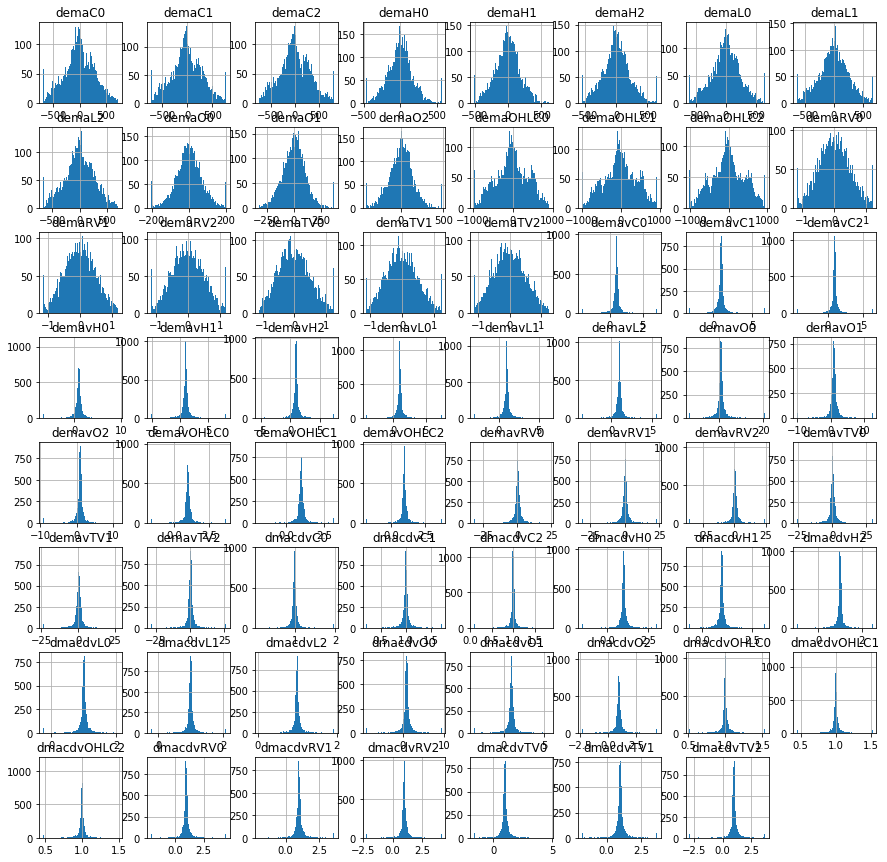

In [52]:
barsv.iloc[:, fi:nind].hist(figsize=(15,15), bins=100);

Avoid removing nan rows due nan cell.  
Let robust scaler solve that.  

In [53]:
bars.iloc[:, fi:nind] = bars.iloc[:, fi:nind].fillna(0) # dont know why quantile Transform
# dont work with nans like it is supossed to

In [54]:
bars = bars.apply(lambda x: x.clip(*x.quantile([0.001, 0.999]).values), axis=0)

### Standardizing Signal Features

#### Quantile Transform

Note:. NaNs are treated as missing values: disregarded in fit, and maintained in transform. (NOT SURE)

In [55]:
ibandsgs = [ bars.columns.get_loc('bandsg'+str(j)) for j in range(nbands) ]
# y target class
id = bars.columns.get_loc('dated')

In [56]:
from sklearn import preprocessing
quantile_transformer = preprocessing.QuantileTransformer(
    output_distribution='normal', random_state=0)

In [57]:
bars.iloc[:, id] = ((bars.iloc[:, id] - bars.iloc[:, id].mean())/
                         bars.iloc[:, id].std()) # normalize variance=1 mean=0

In [58]:
# more features 
bars.iloc[:, list(range(fi,nind))] = quantile_transformer.fit_transform(
    bars.iloc[:, list(range(fi,nind))].values)

In [59]:
# can only have values 0, 1, 2 turn it in normalized floats
bars.iloc[:, ibandsgs] = ((bars.iloc[:, ibandsgs] - bars.iloc[:, ibandsgs].mean())/
                         bars.iloc[:, ibandsgs].std()) # normalize variance=1 mean=0

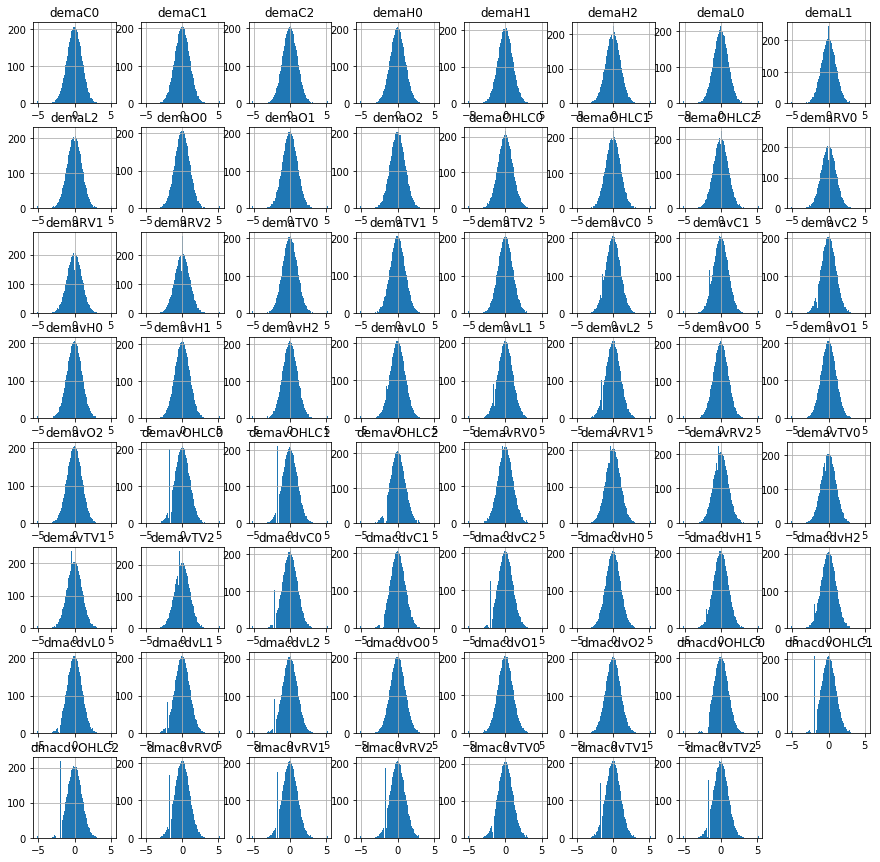

In [60]:
bars[bars.columns[fi:nind]].hist(figsize=(15,15), bins=100);

In [61]:
# y target class column index
iybands = [ bars.columns.get_loc('y'+str(j)) for j in range(nbands)]

### Assembly the real feature vector X

### Using previous window size signal features before the confirmed class [0, 1, 2]

In [62]:
bars.iloc[:, [*iybands, *ibandsgs, *list(range(fi,nind)), id]].head(2)

,y0,y1,y2,bandsg0,bandsg1,bandsg2,demaO0,demavO0,dmacdvO0,demaO1,...,demaOHLC0,demavOHLC0,dmacdvOHLC0,demaOHLC1,demavOHLC1,dmacdvOHLC1,demaOHLC2,demavOHLC2,dmacdvOHLC2,dated
time,,,,,,,,,,,,,,,,,,,,,
2018-11-27 11:55:00,NaN,NaN,NaN,-0.242351,-0.217985,-0.196239,0.017565,-0.890172,-1.269664,-0.026349,...,0.04518,-1.679303,-1.959536,0.04518,-1.669112,-1.942703,0.04518,-1.659093,-1.926403,0.935951
2018-11-27 11:56:00,NaN,NaN,NaN,-0.242351,-0.217985,-0.196239,0.017565,-0.890172,-1.269664,-0.026349,...,0.04518,-1.679303,-1.959536,0.04518,-1.669112,-1.942703,0.04518,-1.659093,-1.926403,0.935951


In [63]:
len(bars)

4970

In [64]:
(len(bars)*nfeatures*window)/(1024*1024) # MBytes

6.668844223022461

In [65]:
X, y, time = bbands.xyTrainingPairs(bars.iloc[:, [*iybands, *ibandsgs, *list(range(fi,nind)), id]].values, 
                             window, nfeatures, nbands)
time = time.astype(int)
y = y.astype(int)

In [66]:
len(X), len(y)

(435, 435)

### Sample feature vector X and y

### Remember those are signal X and target class  y for only one band each pair 

In [67]:
X[1]

array([ 2.36476196, -0.21798519, -0.19623901, ..., -1.65909278,
       -1.92640315,  0.93595053])

In [68]:
y[1]

1

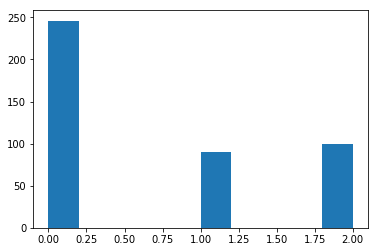

In [69]:
plt.hist(y);

There are more exits than entries due the fact that latest data cannot use 1's for training
due future. 

In [70]:
len(y[y == 1]), len(y[y == 2])

(90, 99)

### Save vectors 

It's a pain have to run everything back again

In [71]:
X.shape, y.shape, time.shape

((435, 1407), (435,), (435,))

In [72]:
(X.shape[0]*X.shape[1]*8)/(1024*1024) # MB

4.669532775878906

### Waking forward cross-validation


In [73]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
#from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report
from joblib import Parallel, delayed
from sklearn.metrics import average_precision_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import classification_report, f1_score, recall_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
#from sklearn.preprocessing import label_binarize
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from algos.nn.torchCV import sKFold
from sklearn import metrics

In [74]:
window=21

In [75]:
nmax=len(X)
nmax=4500
window=int(window) # number of previous signals to use for traning 

In [76]:
window, nmax

(21, 4500)

In [77]:
twindow = int(window)*5

window any of the previous 21 signals had 3 

In [78]:
twindow

105

Time of the signals inside the window for training

In [79]:
time[:twindow] # first 75 samples took 387 minutes to assembly

array([  21,   23,   24,   42,   44,   61,   66,   67,  163,  171,  202,
        209,  212,  215,  216,  242,  243,  302,  331,  361,  364,  365,
        376,  406,  407,  455,  471,  481,  486,  487,  513,  518,  520,
        529,  540,  542,  553,  564,  570,  584,  586,  712,  717,  732,
        741,  760,  774,  804,  813,  826,  829,  831,  832,  854,  864,
        880,  882,  891,  920,  921,  946,  947,  960,  965,  989,  990,
       1000, 1001, 1007, 1008, 1019, 1032, 1033, 1034, 1110, 1113, 1120,
       1122, 1123, 1146, 1147, 1155, 1156, 1158, 1166, 1174, 1180, 1181,
       1190, 1211, 1233, 1241, 1266, 1273, 1295, 1296, 1299, 1304, 1327,
       1330, 1338, 1339, 1357, 1360, 1412])

In [80]:
max(time[:twindow])/(60) # hours of signals

23.533333333333335

In [81]:
np.alltrue(np.isin([0, 1], [1, 2, 3, 4]))

False

In [82]:
cm = confusion_matrix([1, 1, 1, 1, 2, 1], [1, 1, 1, 1, 1, 1])

In [83]:
cm

array([[5, 0],
       [1, 0]])

In [84]:
sum(cm[:, 1])   

0

In [85]:
sum(cm[0, :]), sum(cm[1, :])

(5, 1)

In [88]:
# nique([1, 1, 0, 0, 2, 0]))

In [89]:
p0 = None

In [90]:
np.count_nonzero([True, False, 1])

2

In [ ]:
### What I care most is about the precision 
### of the entries
def scoremin1(y_true, y_pred):
    """
    min precision of the three classes
    * 0 if one of the classes has no ocurrences 
    (nor support nor true positive or false positive) 
    
    that due just cross-validation-grid-search \\
    that requires a (single value)
    
    Just-works for a model that is trainned with 3 classes!
    
    """
    cm = confusion_matrix(y_true, y_pred)
    # support is total number of 0 ocurrences, # total number of 1 ocurrences  # total number of 2 ocurrences
    if cm.shape[0] < 2: # 'low-info'
        return 
    # precision is true positive / (true positive + false positive)
    if cm.shape[0] == 2: # 'good-info'
        uniques = np.unique(np.concatenate(y_true, y_pred))        
        if np.alltrue(np.isin([0, 1], uniques)):
            n0, n1 = sum(cm[0, :]), sum(cm[1, :]) # support 
            tpfp0, tpfp1 = sum(cm[:, 0]), sum(cm[:, 1])   
            # tpf1 == 0 or tpfp0 == 0 # class 1 or 0 not predicted altough on truth vector
            # cannot calculate precision for that class  - 'a little less info'
            p0 = cm[0,0]/tpfp0 if tpfp0 > 0 else np.nan;
            p1 = cm[1,1]/tpfp0 if tpfp1 > 0 else np.nan;
        elif np.alltrue(np.isin([0, 2], uniques)):
            n0, n2 = sum(cm[0, :]), sum(cm[1, :]) 
            tpfp0, tpfp2 = sum(cm[:, 0]), sum(cm[:, 1])  
            # tpf0 == 0 or tpfp2 == 0 # class 0 or 2 not predicted altough on truth vector
            # cannot calculate precision for that class  - 'a little less info' 
            p0 = cm[0,0]/tpfp0 if tpfp0 > 0 else np.nan;
            p2 = cm[1,1]/tpfp0 if tpfp2 > 0 else np.nan;
        elif np.alltrue(np.isin([1, 2], uniques)): 
            n1, n2 = sum(cm[0, :]), sum(cm[1, :]) 
            tpfp1, tpfp2 = sum(cm[:, 0]), sum(cm[:, 1])   
            # tpf1 == 0 or tpfp2 == 0 # class 1 or 2 not predicted altough on truth vector
            # cannot calculate precision for that class  - 'a little less info'  
            p0 = cm[0,0]/tpfp1 if tpfp1 > 0 else np.nan;
            p1 = cm[1,1]/tpfp2 if tpfp2 > 0 else np.nan;                 
        if np.count_nonzero([ p0 != np.nan, p1 != np.nan, p2 != np.nan ]) > 1:
            # if two of p0, p1, p2 not nan 'good-info' + 'good' 
            pass;
        else:
            # if one of p0, p1, p2 not nan 'good-info' + 'ok'  
            pass;
        
    elif cm.shape[0] == 3 # 'nice-info'
        n0, n1, n2 = sum(cm[0, :]), sum(cm[1, :]), sum(cm[2, :]) # support  
        
    if n0 == 0 or n1 == 0 or n2 == 0:  # no ocurrences
        return np.nan    
    
    tpfp0, tpfp1, tpfp2 = sum(cm[:, 0]), sum(cm[:, 1]), sum(cm[:, 2])
    if tpfp0 == 0 or tpfp1 == 0 or tpfp2 == 0: # not true or false positives
        return np.nan
    p0, p1, p2 = cm[0,0]/tpfp0, cm[1,1]/tpfp1, cm[2,2]/tpfp2
    return min(p1)

In [ ]:
### What I care most is about the precision 
### of the entries
def scoreModel(y_true, y_pred):
    """
    min precision of the three classes
    * 0 if one of the classes has no ocurrences 
    (nor support nor true positive or false positive) 
    
    that due just cross-validation-grid-search \\
    that requires a (single value)
    """
    cm = confusion_matrix(y_true, y_pred)
    # support is total number of 0 ocurrences, # total number of 1 ocurrences  # total number of 2 ocurrences
    if cm.shape[0] < 2:
        return 0
    if cm.shape[0] == 3 
        n0, n1, n2 = sum(cm[0, :]), sum(cm[1, :]), sum(cm[2, :]) # support     
    else:
        n0, n1, n2 = sum(cm[0, :]), sum(cm[1, :]), sum(cm[2, :]) # support     
        
    if n0 == 0 or n1 == 0 or n2 == 0:  # no ocurrences
        return np.nan    
    # precision is true positive / (true positive + false positive)
    tpfp0, tpfp1, tpfp2 = sum(cm[:, 0]), sum(cm[:, 1]), sum(cm[:, 2])
    if tpfp0 == 0 or tpfp1 == 0 or tpfp2 == 0: # not true or false positives
        return np.nan
    p0, p1, p2 = cm[0,0]/tpfp0, cm[1,1]/tpfp1, cm[2,2]/tpfp2
    return min(p1)

In [80]:
def scoremincv(y_true, y_pred):
    """
    min precision of the three classes
    * 0 if one of the classes has no ocurrences 
    (nor support nor true positive or false positive) 
    
    that due just cross-validation-grid-search \\
    that requires a (single value)
    """
    cm = confusion_matrix(y_true, y_pred)
    # support is total number of 0 ocurrences, # total number of 1 ocurrences  # total number of 2 ocurrences
    if cm.shape[0] < 3:
        return np.nan
    n0, n1, n2 = sum(cm[0, :]), sum(cm[1, :]), sum(cm[2, :]) # support     
    if n0 == 0 or n1 == 0 or n2 == 0:  # no ocurrences
        return np.nan    
    # precision is true positive / (true positive + false positive)
    tpfp0, tpfp1, tpfp2 = sum(cm[:, 0]), sum(cm[:, 1]), sum(cm[:, 2])
    if tpfp0 == 0 or tpfp1 == 0 or tpfp2 == 0: # not true or false positives
        return np.nan
    p0, p1, p2 = cm[0,0]/tpfp0, cm[1,1]/tpfp1, cm[2,2]/tpfp2
    return min(p0, p1, p2)




# ### TODO FOR THE FUTURE
# ALSO USE THE ROC CURVE FOR MULTICLASS... altough don't know how to do
# informadness may be usefull for class 0 and class 2 for class 1 precision is 
# all that matters. Maybe write something about it.
# def score3(ytrue, ypred):
#     """
#     return precision array with value of each class
#         [0, 1, 2] sequence of precisions
#         * nan if one of the classes has no ocurrences 
#         (nor support nor true positive or false positive) 
#         or even not present         
    
#     # might be present 0    
#     # 0 -  -
#     # - 1  -
#     # - -  2
#     # 0 1  -                
#     # 0 -  2
#     # - 1  2    
#     # 0 1  2

#     """
#     cm = confusion_matrix(ytrue, ypred)        
    
# #     @jit(nopython=True)
# #     def 
    
#     ey = np.unique(np.append(ytrue, ypred)) # existent classes present 
#     # better fill in with fake data so we can use the complete confusion matrix
#     ny = len(ey)
#     if ny==2:
#      # 0, 1 / 0, 2 / 1, 2    
        
#     elif ny==1:
        
    
#     else:
        
    
    
    
    
#     # support is total number of 0 ocurrences, # total number of 1 ocurrences  # total number of 2 ocurrences
#     if cm.shape[0] < 3:
#         return np.nan, np.nan, np.nan
    
#     # support 
#     n0, n1, n2 = sum(cm[0, :]), sum(cm[1, :]), sum(cm[2, :]) # support         
# #     if n0 == 0 or n1 == 0 or n2 == 0:  # no ocurrences
# #         return 0 # classifiying as zero is too punitivy nan is better
#     # precision is true positive / (true positive + false positive)
#     tpfp0, tpfp1, tpfp2 = sum(cm[:, 0]), sum(cm[:, 1]), sum(cm[:, 2])
#     tpfp0 = np.nan if tpfp0 == 0 or n0 == 0 else tpfp0 # not true or false positives
#     tpfp1 = np.nan if tpfp1 == 0 or n1 == 0 else tpfp1 # not true or false positives
#     tpfp2 = np.nan if tpfp2 == 0 or n2 == 0 else tpfp2 # not true or false positives
#     p0, p1, p2 = cm[0,0]/tpfp0, cm[1,1]/tpfp1, cm[2,2]/tpfp2
#     return p0, p1, p2

In [81]:
# my score function only one float as return
myscore = make_scorer(scoremin1)

Due joblib having problems calling this code in torchCV, could not serialize. Dont know why..

In [82]:
def indexSequentialFolds(length, size, verbose=True):
    """
    Given length (maximum array size) and fold size (window size):
    Returns
     * array dim=2: start and end index of each fold
    Total number of folds is the len()
    """
    nfolds = length-size
    indexfold = np.zeros((nfolds, 2), dtype=int) # begin and end 2
    for i in range(nfolds):
        indexfold[i, :] = np.array([i, i+size], dtype=int)
    if verbose:
        print('number folds', nfolds)
    return indexfold

class skfold(object):
    """
    Sequential folds suitable for stock prediction
    cross-validation 'alike' k-folds sklearn cv-search compatible
    """
    def __init__(self, X, foldsize=None, splits=4, ratio=0.7, kind='default', n=None):
        """
        Create training, test sets indexes based on number of splits.

        `X` feature vector
        `foldsize` is the window size non-overlaping for X, Y vectors
        `splits` if `foldsize` is not specified this is the total number of splits.
        default is 4 slices/splits
        `ratio` is the percentage of the fold window for due the training set
        the complement is the validation and prediction.
        
        kind: can be one of those
            'randn' where n specify number of splits
            'lastn' where n specify number of splits
             None default using all possible splits

        default is ~70% training, ~20% validation 
        """
        length = len(X) # max array size
        assert splits < length, "splits must be smaller than X length"
        if splits < 2:
            assert splits > 2, "at least a split in two is expected"
        if foldsize is None: # fold calculated by number of splits or slices
            foldsize = length//splits        
        ntrain = int(foldsize*ratio)
        ntest  = foldsize - ntrain
        # calculate split indexes and real number of splits/slices
        indexes = indexSequentialFolds(length, foldsize, verbose=False)
        self.kind = kind
        self.ntrain = ntrain # training set number of samples
        self.ntest = ntest # validaton set number of samples
        self.split_indexes = indexes # start, end pair index for each fold
        # changed due gridsearch cv
        self.n = len(indexes)
        if self.kind == 'randn':
            self.split = self._srandn
            self.n_splits  = self.n
        elif self.kind == 'lastn':
            self.split = self._slastn
            self.n_splits  = self.n
        else: # default
            self.split = self._splits                 

    def get_n_splits(self,  X=None, y=None, groups=None):
        """return number of splits"""
        return self.n_splits
    
    def _srandn(self, X=None, y=None, groups=None):
        """
        yields n random split groups  indexes
        """
        ntrain, ntest = self.ntrain, self.ntest        
        for i in range(self.n_splits):
            start, end = self.split_indexes[np.random.randint(self.n)]
            sval = start+ntrain
            yield list(range(start, sval)), list(range(sval, end))
        
    def _slastn(self, X=None, y=None, groups=None):
        """
        yields last n split group indexes
        """
        ntrain, ntest = self.ntrain, self.ntest        
        for i in range(self.n_splits):
            start, end = self.split_indexes[-(1+i)]
            sval = start+ntrain
            yield list(range(start, sval)), list(range(sval, end))
    
    def _splits(self, X=None, y=None, groups=None):
        """
        Return training, validation indexes
            Xtrain, ytrain, Xscore, yscore
        """
        ntrain, ntest = self.ntrain, self.ntest
        for start, end in self.split_indexes:
            sval = start+ntrain
            yield list(range(start, sval)), list(range(sval, end))

In [83]:
nsplits=4  # number of cross validation splits with time-series-split
def function(X, y, i):  
    """i index of prediction on the parent X vector"""
    #scv = TimeSeriesSplit(n_splits=nsplits)
    # this here garantes 4 folds 
    kfold = skfold(X[:-1], foldsize=len(X[:-1])-nsplits, ratio=0.9)
    svm = ExtraTreesClassifier(n_estimators=150, verbose=0)
    results = [np.nan]*(nsplits*1+1+3+1)    
    try:
        # if don't have tree-classes for training cannot train model
        if len(np.unique(y[:-1])) == 3:
            scores = [np.nan]*nsplits
            #             scores = []
            #             for train, test in kfold.split():
            #                 Xt, Xs = X[train], X[test]
            #                 yt, ys = y[train], y[test]
            #                 svm.fit(Xt, yt)
            #                 ypred = svm.predict_proba(Xs)
            #                 scores.append(scoremin1(ys, ypred))
            svm.fit(X[:-1], y[:-1])
            ypred = svm.predict_proba(X[-1:])
            results = [i, *scores, y[-1], *ypred[0]]
    except Exception as e:
        print(e)
        raise e       
    return results

Ok == all zero 100%
2 classes == fair 80%

In [84]:
# nsplits=10
# i = np.random.randint(len(X)-twindow)
# print(i, y[i:i+twindow])
# svm = ExtraTreesClassifier(n_estimators=80, verbose=0)
# kfold = skfold(X[i:i+twindow], foldsize=twindow-nsplits, ratio=0.7, kind='lastn')
# print(kfold.ntrain, kfold.ntest, kfold.n_splits)
# cross_val_score(svm, X[i:i+twindow], y[i:i+twindow], cv=kfold, scoring=myscore)

In [85]:
# results = []
# for i in progressbar(np.random.randint(len(X)-twindow, size=nmax)):
#     results.append(function(X[i:i+twindow], y[i:i+twindow])) 

In [155]:
nmax=18500

In [156]:
from joblib import Parallel, delayed

if __name__ == '__main__':
     results = Parallel(n_jobs=6, verbose=1)(
         delayed(function)(X[i:i+twindow], y[i:i+twindow], i+twindow-1) 
         for i in np.random.randint(len(X)-twindow, size=nmax))
# if using jit in any of the methods above parallel doesnt work

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    2.7s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:    7.0s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:   14.0s
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:   23.5s
[Parallel(n_jobs=6)]: Done 1238 tasks      | elapsed:   35.8s
[Parallel(n_jobs=6)]: Done 1788 tasks      | elapsed:   50.8s
[Parallel(n_jobs=6)]: Done 2438 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done 3188 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done 4038 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done 4988 tasks      | elapsed:  2.3min
[Parallel(n_jobs=6)]: Done 6038 tasks      | elapsed:  2.8min
[Parallel(n_jobs=6)]: Done 7188 tasks      | elapsed:  3.3min
[Parallel(n_jobs=6)]: Done 8438 tasks      | elapsed:  3.9min
[Parallel(n_jobs=6)]: Done 9788 tasks      | elapsed:  4.5min
[Parallel(n_jobs=6)]: Done 11238 tasks      | elapsed:  5.2mi

### Max_features set or estimators less than 100 give precision for class 1 less than 50%

In [157]:
results = np.array(results)

In [158]:
results.shape

(18500, 9)

In [159]:
#np.unique(results)

In [160]:
nsplits = 4

In [161]:
#names = ['s'+str(j)+str(i) for j in range(nsplits)  for i in range(3) ] + ['ytrue', 'ypred']
names = ['i'] + ['s'+str(j) for j in range(nsplits) ] + ['ytrue', 'y0', 'y1', 'y2']

In [162]:
#results = pd.DataFrame(results, columns=['mprec', 'precision', 'recall', 'ypred', 'ytrue'])
dresults = pd.DataFrame(results, columns=names)

In [163]:
dresults.head()

,i,s0,s1,s2,s3,ytrue,y0,y1,y2
0,32621.0,NaN,NaN,NaN,NaN,0.0,0.353333,0.293333,0.353333
1,18954.0,NaN,NaN,NaN,NaN,2.0,0.246667,0.086667,0.666667
2,24665.0,NaN,NaN,NaN,NaN,2.0,0.406667,0.093333,0.500000
3,39748.0,NaN,NaN,NaN,NaN,0.0,0.573333,0.220000,0.206667
4,14155.0,NaN,NaN,NaN,NaN,1.0,0.400000,0.440000,0.160000


Try to quantify information obtained about the model with the cross-validation.  

Quantify information obtained by class.  

info = sum( non-nan lass) for n in nsplits  

In [164]:
dresults.dropna(how='all', inplace=True)

In [165]:
len(results)

18500

precision_score?

    ``'binary'``:
        Only report results for the class specified by ``pos_label``.
        This is applicable only if targets (``y_{true,pred}``) are binary.
    ``'micro'``:
        Calculate metrics globally by counting the total true positives,
        false negatives and false positives.
    ``'macro'``:
        Calculate metrics for each label, and find their unweighted
        mean.  This does not take label imbalance into account.
    ``'weighted'``:
        Calculate metrics for each label, and find their average, weighted
        by support (the number of true instances for each label). This
        alters 'macro' to account for label imbalance; it can result in an
        F-score that is not between precision and recall.
    ``'samples'``:
        Calculate metrics for each instance, and find their average (only
        meaningful for multilabel classification where this differs from
        :func:`accuracy_score`).

In [166]:
yclass = np.argmax(dresults.values[:, -3:], axis=-1)
dresults['prob'] = np.max(dresults.values[:, -3:], axis=-1)
dresults['ypred'] = yclass

In [167]:
dresults.head()

,i,s0,s1,s2,s3,ytrue,y0,y1,y2,prob,ypred
0,32621.0,NaN,NaN,NaN,NaN,0.0,0.353333,0.293333,0.353333,0.353333,0
1,18954.0,NaN,NaN,NaN,NaN,2.0,0.246667,0.086667,0.666667,0.666667,2
2,24665.0,NaN,NaN,NaN,NaN,2.0,0.406667,0.093333,0.500000,0.500000,2
3,39748.0,NaN,NaN,NaN,NaN,0.0,0.573333,0.220000,0.206667,0.573333,0
4,14155.0,NaN,NaN,NaN,NaN,1.0,0.400000,0.440000,0.160000,0.440000,1


### Receiver characteritics

0.7335227181349752
0.6902251945926633
0.9595975229180581


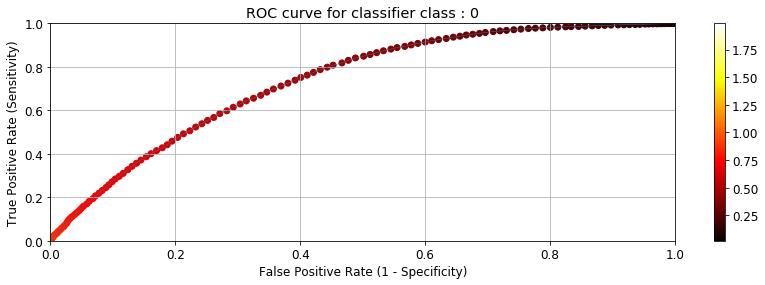

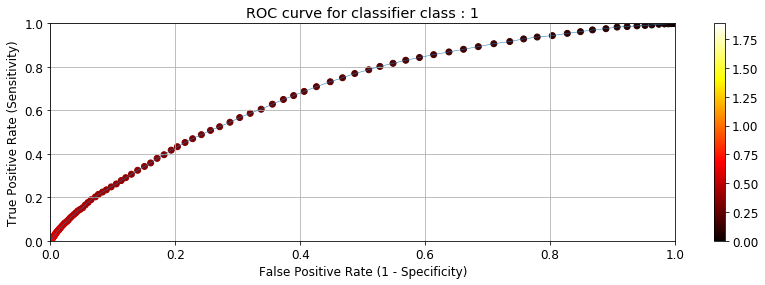

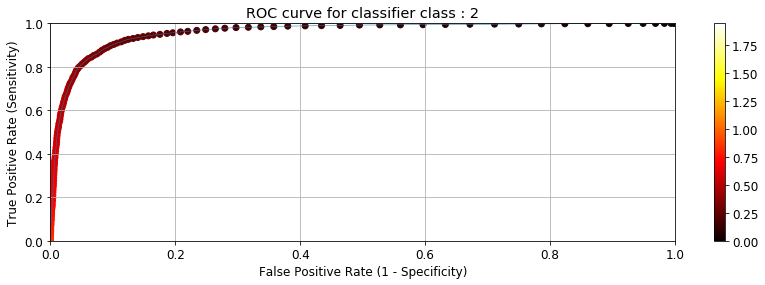

In [168]:
def plotroc(ytrue, ytest, classy):
    plt.figure(figsize=(14,4))
    fpr, tpr, thresholds = metrics.roc_curve(ytrue, ytest)
    plt.plot(fpr, tpr, lw=0.5)
    plt.scatter(fpr, tpr, c=thresholds, cmap='hot')
    plt.colorbar()
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.rcParams['font.size'] = 12
    plt.title('ROC curve for classifier class : '+classy)
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.grid(True)

classy = dresults.copy()[['ytrue', 'y0']]
classy.loc[classy.ytrue == 0, 'ytrue'] = -1 # the 0 trues
classy.loc[classy.ytrue != -1, 'ytrue'] = 0 # what is not zero
classy.loc[classy.ytrue == -1, 'ytrue'] = 1 # set as one (binary roc)
print(metrics.roc_auc_score(classy.ytrue, classy['y0']))
plotroc(classy.ytrue, classy['y0'], '0')
classy = dresults.copy()[['ytrue', 'y1']]
classy.loc[classy.ytrue != 1, 'ytrue'] = 0
plotroc(classy.ytrue, classy.y1, '1')
print(metrics.roc_auc_score(classy.ytrue, classy['y1']))
classy = dresults.copy()[['ytrue', 'y2']]
classy.loc[classy.ytrue != 2, 'ytrue'] = 0 # what is not zero
classy.loc[classy.ytrue == 2, 'ytrue'] = 1 # set as one (binary roc)
plotroc(classy.ytrue, classy.y2, '2')
print(metrics.roc_auc_score(classy.ytrue, classy['y2']))

In [169]:
# macro : unweighted mean of each class precision
# weighted : weight average using support (ocorrences for each class)
precision_score(dresults.ytrue, dresults.ypred, average='macro')

0.6452751099835081

In [170]:
f1_score(dresults.ytrue, dresults.ypred, average='macro')

0.5985447605965479

In [171]:
# None precision for each class
precision_score(dresults.ytrue, dresults.ypred, average='macro')

0.6452751099835081

In [172]:
recall_score(dresults.ytrue, dresults.ypred, average='macro')

0.5993458040933548

### What is the necessary precision for each class

1. what is the necessary precision for each class?
2. what is the best metric to evaluate the classifier?
3. how to analyse 1,2 consider the goal of profit $$$ 

#### Recall - Wikipedia
Suppose a computer program for recognizing dogs in photographs identifies 8 dogs in a picture containing 12 dogs and some cats. Of the 8 identified as dogs, 5 actually are dogs (true positives), while the rest are cats (false positives). The program's precision is 5/8 while its recall is 5/12.  
When a search engine returns 30 pages only 20 of which were relevant while failing to return 40 additional relevant pages, its precision is 20/30 = 2/3 while its recall is 20/60 = 1/3. So, in this case, precision is "how useful the search results are", and recall is "how complete the results are"

informadness is better... according people...

Precision = quality
Recall = quantity


In [173]:
from sklearn.metrics import confusion_matrix, classification_report

In [174]:
# true class above, predicted class on the rows
cm = confusion_matrix(dresults.ytrue, dresults.ypred)
print(cm)

[[7882  914  512]
 [3488  776   81]
 [1012   90 3745]]


https://en.wikipedia.org/wiki/Confusion_matrix

In [175]:
print(classification_report(dresults.ytrue, dresults.ypred))

              precision    recall  f1-score   support

         0.0       0.64      0.85      0.73      9308
         1.0       0.44      0.18      0.25      4345
         2.0       0.86      0.77      0.82      4847

   micro avg       0.67      0.67      0.67     18500
   macro avg       0.65      0.60      0.60     18500
weighted avg       0.65      0.67      0.64     18500



#### Trying to clip by model score

In [176]:
dresults.head(1)

,i,s0,s1,s2,s3,ytrue,y0,y1,y2,prob,ypred
0,32621.0,NaN,NaN,NaN,NaN,0.0,0.353333,0.293333,0.353333,0.353333,0


In [177]:
dresults['mprec'] = (dresults.s0*dresults.s1*dresults.s2*dresults.s3)**(1./4)

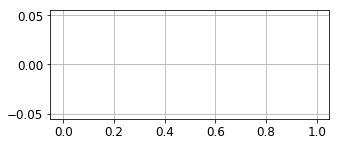

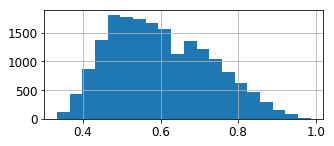

In [178]:
plt.figure(figsize=(5,2))
dresults.mprec.hist(bins=20)
plt.figure(figsize=(5,2))
dresults.prob.hist(bins=20)

In [179]:
#from sklearn.metrics import log_loss

In [180]:
dresults.ytrue.unique()

array([0., 2., 1.])

In [181]:
dresults.ypred.unique()

array([0, 2, 1], dtype=int64)

In [182]:
#log_loss(dresults.ytrue.astype(int), dresults.ypred)

In [183]:
#sns.jointplot(results.s1*results.s2*results.s3, results.precision, kind='hex')

#### Clipping results by model score works but removes much more samples than by probability estimate

In [184]:
#print(classification_report(dresults[dresults.mprec > .6].ytrue, dresults[dresults.mprec > .6].ypred))

#### Clipping by the max probility class estimate

In [185]:
print(classification_report(dresults[dresults.prob > .58].ytrue, dresults[dresults.prob > .58].ypred))

              precision    recall  f1-score   support

         0.0       0.70      0.95      0.80      4971
         1.0       0.54      0.08      0.13      2013
         2.0       0.94      0.92      0.93      2413

   micro avg       0.75      0.75      0.75      9397
   macro avg       0.72      0.65      0.62      9397
weighted avg       0.72      0.75      0.69      9397



In [204]:
print(classification_report(dresults[dresults.prob > .55].ytrue, dresults[dresults.prob > .55].ypred))

              precision    recall  f1-score   support

         0.0       0.69      0.94      0.79      5815
         1.0       0.53      0.09      0.16      2467
         2.0       0.93      0.90      0.92      2810

   micro avg       0.74      0.74      0.74     11092
   macro avg       0.72      0.64      0.62     11092
weighted avg       0.71      0.74      0.68     11092



In [205]:
print(classification_report(dresults[dresults.prob > .60].ytrue, dresults[dresults.prob > .60].ypred))

              precision    recall  f1-score   support

         0.0       0.70      0.95      0.81      4483
         1.0       0.52      0.07      0.12      1750
         2.0       0.94      0.92      0.93      2173

   micro avg       0.76      0.76      0.76      8406
   macro avg       0.72      0.65      0.62      8406
weighted avg       0.73      0.76      0.70      8406



In [206]:
print(classification_report(dresults[dresults.prob > .75].ytrue, dresults[dresults.prob > .75].ypred))

              precision    recall  f1-score   support

         0.0       0.75      0.98      0.85      1511
         1.0       0.69      0.02      0.04       478
         2.0       0.95      0.97      0.96       627

   micro avg       0.80      0.80      0.80      2616
   macro avg       0.80      0.66      0.62      2616
weighted avg       0.79      0.80      0.73      2616



In [202]:
print(classification_report(dresults[dresults.prob > .9].ytrue, dresults[dresults.prob > .9].ypred))

              precision    recall  f1-score   support

         0.0       0.80      1.00      0.89       120
         1.0       0.00      0.00      0.00        29
         2.0       1.00      0.94      0.97        16

   micro avg       0.82      0.82      0.82       165
   macro avg       0.60      0.65      0.62       165
weighted avg       0.68      0.82      0.74       165



C:\Users\alferreira\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\alferreira\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\alferreira\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [190]:
392/len(dresults)

0.02118918918918919

### GridSearch of paramsn with c-validation Sequential Folds - Time Series Split 5 folds

window*5 with 5 splits

In [140]:
param_grid = [
  {'n_estimators' : [ 100, 150, 300, 500, 1000]}

In [141]:
X.shape

(55682, 1407)

In [142]:
svm = ExtraTreesClassifier()

In [143]:
#ys = y[5000:5000+window*5]
#yb = label_binarize(ys, classes=[0, 1, 2])

In [144]:
twindow

84

In [145]:
#tscv = TimeSeriesSplit(n_splits=20, max_train_size=twindow//4)
tscv = skfold(X, foldsize=twindow, ratio=0.90, kind='randn', n=10)
tscv.n_splits, tscv.ntrain, tscv.ntest, tscv.kind

(10, 75, 9, 'randn')

#### precision_macro or recall_macro

In [146]:
clf = GridSearchCV(svm, param_grid, cv=tscv, n_jobs=32, scoring=, verbose=5) # myscore is breaking the joblib

In [147]:
clf.fit(X,  y)

Fitting 10 folds for each of 192 candidates, totalling 1920 fits


[Parallel(n_jobs=32)]: Done   8 tasks      | elapsed:    9.0s
[Parallel(n_jobs=32)]: Done  98 tasks      | elapsed:  1.6min
[Parallel(n_jobs=32)]: Done 224 tasks      | elapsed:  3.8min
[Parallel(n_jobs=32)]: Done 386 tasks      | elapsed:  6.5min
[Parallel(n_jobs=32)]: Done 584 tasks      | elapsed:  9.8min
[Parallel(n_jobs=32)]: Done 818 tasks      | elapsed: 13.7min
[Parallel(n_jobs=32)]: Done 1088 tasks      | elapsed: 18.3min
[Parallel(n_jobs=32)]: Done 1394 tasks      | elapsed: 23.5min
[Parallel(n_jobs=32)]: Done 1736 tasks      | elapsed: 29.2min
[Parallel(n_jobs=32)]: Done 1920 out of 1920 | elapsed: 32.4min finished


GridSearchCV(cv=<__main__.skfold object at 0x000002439B0EAC50>,
       error_score='raise',
       estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=32,
       param_grid=[{'n_estimators': [20, 50, 100, 150], 'min_samples_split': [0.9, 0.5, 0.15], 'max_features': [200, 400, 1000, 1407], 'max_depth': [5, 15, 22, 35]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='precision_macro', verbose=5)

### Results

In [148]:
clf.best_params_

{'max_depth': 15,
 'max_features': 400,
 'min_samples_split': 0.15,
 'n_estimators': 20}

In [ ]:
clf.best_params_

In [162]:
params = pd.DataFrame(clf.cv_results_['params'])
params['means'] = clf.cv_results_['mean_test_score']
params['stds'] = clf.cv_results_['std_test_score']

Looking too random, doesnt seam to be related to param choice. 

Maybe the metrics is not good. 

In [181]:
ExtraTreesClassifier?

In [170]:
len(params)

192

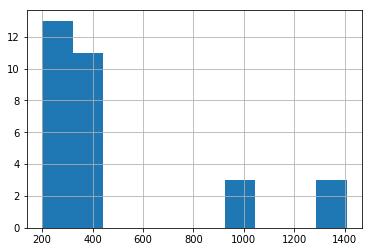

In [189]:
params.sort_values(by='means', ascending=False)[:30].max_features.hist()

This is too random, metric seams not good!

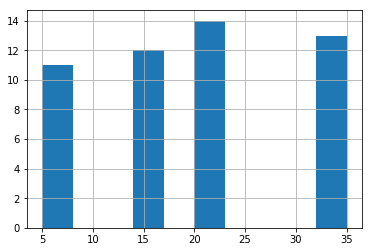

In [187]:
params.sort_values(by='means', ascending=False)[:50].max_depth.hist()

## Generate predictions for validation on Mt5

In [177]:
nsplits=4  # number of cross validation splits with time-series-split
def function(X, y, i):  
    """i index of prediction on the parent X vector"""
    #scv = TimeSeriesSplit(n_splits=nsplits)
    # this here garantes 4 folds 
    kfold = skfold(X[:-1], foldsize=len(X[:-1])-nsplits, ratio=0.9)
    svm = ExtraTreesClassifier(n_estimators=70, verbose=0, max_features=300)
    results = [np.nan]*(1+1+3)    
    try:
        # if don't have tree-classes for training cannot train model
        if len(np.unique(y[:-1])) == 3:
            svm.fit(X[:-1], y[:-1])
            ypred = svm.predict_proba(X[-1:])
            results = [i, y[-1], *ypred[0]]
    except Exception as e:
        print(e)
        raise e       
    return results

In [180]:
dowtime = dow.index

In [183]:
dowtime

DatetimeIndex(['2013-12-02 10:42:00', '2013-12-02 10:43:00',
               '2013-12-02 10:44:00', '2013-12-02 10:45:00',
               '2013-12-02 10:46:00', '2013-12-02 10:47:00',
               '2013-12-02 10:48:00', '2013-12-02 10:49:00',
               '2013-12-02 10:50:00', '2013-12-02 10:51:00',
               ...
               '2018-12-11 17:45:00', '2018-12-11 17:46:00',
               '2018-12-11 17:47:00', '2018-12-11 17:48:00',
               '2018-12-11 17:49:00', '2018-12-11 17:50:00',
               '2018-12-11 17:51:00', '2018-12-11 17:52:00',
               '2018-12-11 17:53:00', '2018-12-11 17:54:00'],
              dtype='datetime64[ns]', name='time', length=502264, freq=None)

In [ ]:
del dowv, dow

In [185]:
len(dowtime), len(X)

(502264, 55697)

In [187]:
nmax = len(X)-twindow
#nmax = 1500

In [188]:
from joblib import Parallel, delayed

if __name__ == '__main__':
     results = Parallel(n_jobs=6, verbose=1)(
         delayed(function)(X[i:i+twindow], y[i:i+twindow], i+twindow-1) 
         for i in range(nmax))
# if using jit in any of the methods above parallel doesnt work

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    1.4s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:    7.6s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:   17.3s
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:   31.3s
[Parallel(n_jobs=6)]: Done 1238 tasks      | elapsed:   49.5s
[Parallel(n_jobs=6)]: Done 1788 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done 2438 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done 3188 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done 4038 tasks      | elapsed:  2.7min
[Parallel(n_jobs=6)]: Done 4988 tasks      | elapsed:  3.4min
[Parallel(n_jobs=6)]: Done 6038 tasks      | elapsed:  4.1min
[Parallel(n_jobs=6)]: Done 7188 tasks      | elapsed:  4.8min
[Parallel(n_jobs=6)]: Done 8438 tasks      | elapsed:  5.7min
[Parallel(n_jobs=6)]: Done 9788 tasks      | elapsed:  6.5min
[Parallel(n_jobs=6)]: Done 11238 tasks      | elapsed:  7.5min
[Parallel(n_jobs=6)]: Done 12788 tasks      | elapsed:  8.5min
[Parallel(

In [189]:
#names = ['s'+str(j)+str(i) for j in range(nsplits)  for i in range(3) ] + ['ytrue', 'ypred']
names = ['i'] + ['ytrue', 'y0', 'y1', 'y2']

In [190]:
#results = pd.DataFrame(results, columns=['mprec', 'precision', 'recall', 'ypred', 'ytrue'])
dresults = pd.DataFrame(results, columns=names)

In [191]:
dresults.head()

,i,ytrue,y0,y1,y2
0,83,1,0.578571,0.421429,0.000000
1,84,1,0.392857,0.521429,0.085714
2,85,0,0.000000,1.000000,0.000000
3,86,2,0.292857,0.050000,0.657143
4,87,2,0.185714,0.028571,0.785714


In [192]:
yclass = np.argmax(dresults.values[:, -3:], axis=-1)
dresults['prob'] = np.max(dresults.values[:, -3:], axis=-1)
dresults['ypred'] = yclass

In [240]:
print(classification_report(dresults[dresults.prob > .80].ytrue, dresults[dresults.prob > .80].ypred))

             precision    recall  f1-score   support

          0       0.81      0.88      0.84      9191
          1       0.69      0.49      0.57      3560
          2       0.94      0.97      0.96      5053

avg / total       0.82      0.83      0.82     17804



In [194]:
predictions = dresults[dresults.prob > 0.8 ]

In [195]:
len(predictions)/len(dresults)

0.3201409742326434

In [196]:
predictions.drop(columns=['ytrue', 'y0', 'y1', 'y2', 'prob'], inplace=True)

/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [197]:
len(predictions[predictions.ypred > 0 ])/len(predictions)

0.434115929004718

In [198]:
predictions = predictions[predictions.ypred > 0]

In [200]:
predictions['time'] = dowtime[ time[ predictions.i ] ]

In [201]:
predictions.set_index('time', drop=True, inplace=True)

In [202]:
predictions.drop(columns='i', inplace=True)

In [203]:
predictions.head()

,ypred
time,
2013-12-04 11:19:00,1
2013-12-04 11:51:00,2
2013-12-04 12:36:00,1
2013-12-04 12:59:00,2
2013-12-04 13:54:00,1


In [206]:
len(predictions)/len(time)

0.13876869490277752

In [208]:
len(time), len(dowtime)

(55697, 502264)

In [210]:
frequency=len(predictions)/len(dowtime)

##### Per day number of orders

In [211]:
frequency*7*60

6.463095105362917

### Turn classes in  

+1 buy -1 sell 

In [222]:
predictions[predictions.ypred == 2] = -1

Sum up orders at the same moment

-negative are sell   
+positive are buy  

In [225]:
predictions = predictions.groupby(predictions.index).sum()

In [227]:
len(predictions)

6939

In [233]:
predictions.ypred.unique()

array([ 1, -1,  2, -2, -3])

Save Predictions for backtesting

In [234]:
predictions.to_pickle('Saulos_predictions_all11.pickle')

In [161]:
metrics['probmax'] = metrics.apply(lambda x:  max(x.predb0, x.predb1), axis=1)

NameError: name 'metrics' is not defined

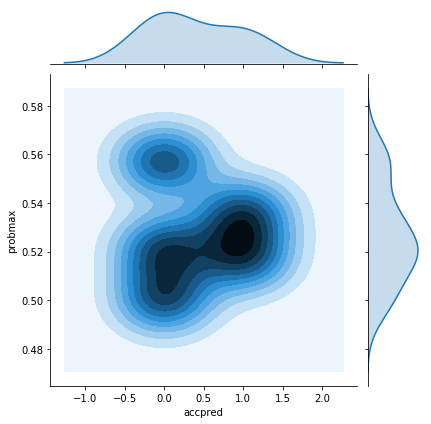

In [94]:
sns.jointplot(metrics.accpred, metrics.probmax, kind='kde')

### Jointplot above suggests 0.8 of cut-off

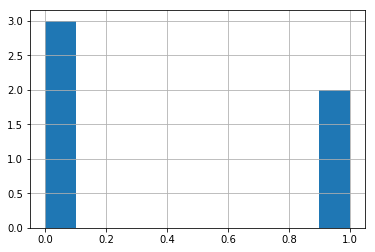

In [95]:
metrics.accpred.hist()

In [96]:
import talib as ta

### Average Accuracy by day

[0.25   0.2525 0.275  0.375  0.475 ]


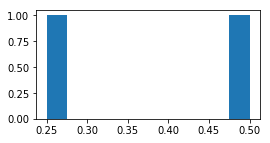

In [97]:
metrics['davpredac'] = ta.SMA(metrics.accpred.values, 4)
plt.figure(figsize=(4,2))
plt.hist(metrics.davpredac.dropna());
print(np.percentile(metrics.davpredac.dropna().values, (0, 1, 10, 50, 90)))
# davpredac_c = ta.SMA(metrics.predac_c.dropna().astype(np.double), 4)
# plt.figure(figsize=(4,2))
# plt.hist(davpredac_c.dropna());
# print(np.percentile(davpredac_c.dropna(), (0, 1, 10, 50, 90)))

### Average Accuracy by week

In [ ]:
metrics['wavpredac'] = ta.SMA(metrics.accpred.values, 20)
plt.figure(figsize=(4,2))
plt.hist(metrics.wavpredac.dropna());
print(np.percentile(metrics.wavpredac.dropna().values, (0, 1, 10, 50, 90)))
# wavpredac_c = ta.SMA(metrics.predac_c.dropna().astype(np.double), 20)
# plt.figure(figsize=(4,2))
# plt.hist(wavpredac_c.dropna());
# print(np.percentile(wavpredac_c.dropna(), (0, 1, 10, 50, 90)))

In [ ]:
metrics['modelscore'] = np.sqrt(metrics.trainac*metrics.validac)

In [ ]:
sns.jointplot(metrics.modelscore, metrics.wavpredac, kind='kde')

In [ ]:
print(np.percentile(metrics.wavpredac[ metrics.modelscore > 0.525 ].dropna(), (0, 1, 10, 50, 90)))

In [ ]:
len(metrics.wavpredac[ metrics.modelscore > 0.78 ].dropna())/len(metrics.wavpredac.dropna())

In [ ]:
metrics[-10:]

In [ ]:
def probability(values):
    percentiles = np.percentile(values, [0, 1, 10, 50, 90])
    print('percentiles are ', percentiles)
    import matplotlib.ticker as plticker
    loc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
    fig = plt.figure(figsize=(10,4))
    ax1 = fig.add_subplot(211);
    ax1.hist(values, bins=20, density=True);
    #ax1.set_xlim(percentiles[0], 5)
    ax1.xaxis.set_major_locator(loc)
    ax1.grid()
    ax2 = fig.add_subplot(212, sharex=ax1)
    ax2.hist(values, bins=20, density=True, cumulative=True);
    ax2.xaxis.set_major_locator(loc)
    ax2.set_ylabel('cumulative percentage (%)')
    ax2.grid()

In [ ]:
probability(metrics.wavpredac[ metrics.modelscore > 0.78 ].dropna());